#### Calling necessary libraries for EDA

In [47]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import seaborn as sns
import matplotlib.pyplot as plt
import uuid

#### Loading the dataset

In [2]:
df = pd.read_csv('resume_screening_5percent_missing.csv')

#### Data Overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    4764 non-null   float64
 1   gender                 4753 non-null   object 
 2   topik_level            4757 non-null   float64
 3   highest_degree         4784 non-null   object 
 4   major_field            4765 non-null   object 
 5   university_type        4757 non-null   object 
 6   gpa                    4749 non-null   float64
 7   experience_years       4757 non-null   float64
 8   num_projects           4768 non-null   float64
 9   internships            4738 non-null   float64
 10  certifications         4760 non-null   float64
 11  has_portfolio          4750 non-null   float64
 12  github_level           4734 non-null   object 
 13  job_field              4775 non-null   object 
 14  resume_length          4751 non-null   float64
 15  cove

The dataset has 5000 rows and 21 columns, including both numerical and categorical columns.

In [4]:
df.head()

,age,gender,topik_level,highest_degree,major_field,university_type,gpa,experience_years,num_projects,internships,...,has_portfolio,github_level,job_field,resume_length,cover_letter_score,tailored_resume,english_level,leadership_experience,military_status,pass_screening
0,28.0,Female,4.0,Bachelor,CS,Regional,3.58,1.8,3.0,0.0,...,0.0,Medium,Software Dev,1.0,4.0,1.0,Medium,0.0,Not Applicable,0.0
1,NaN,Female,2.0,Bachelor,NaN,Other,3.66,1.1,5.0,NaN,...,0.0,Low,Software Dev,1.0,9.0,1.0,Low,0.0,Exempt,0.0
2,34.0,Female,NaN,Bachelor,CS,Foreign,3.80,2.4,3.0,1.0,...,0.0,Medium,NaN,1.0,8.0,1.0,Medium,0.0,Complete,1.0
3,32.0,Male,2.0,Bachelor,CS,SKY,3.78,2.3,2.0,1.0,...,1.0,Medium,Software Dev,NaN,7.0,0.0,High,0.0,Not Applicable,0.0
4,29.0,Male,3.0,Bachelor,Data Science,Other,NaN,1.0,5.0,1.0,...,0.0,NaN,PM,1.0,5.0,1.0,Low,1.0,Complete,0.0


In [5]:
df.isnull().sum()

age                      236
gender                   247
topik_level              243
highest_degree           216
major_field              235
university_type          243
gpa                      251
experience_years         243
num_projects             232
internships              262
certifications           240
has_portfolio            250
github_level             266
job_field                225
resume_length            249
cover_letter_score       256
tailored_resume          269
english_level            241
leadership_experience    253
military_status          245
pass_screening           223
dtype: int64

All columns have missing values.

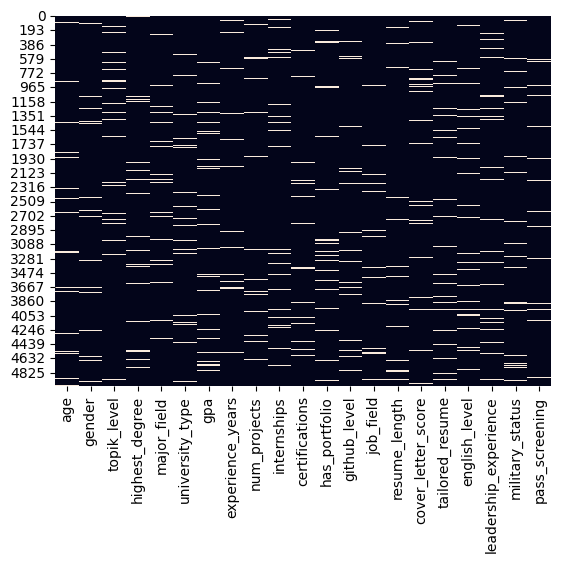

In [7]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

As can be seen on the heatmap, missing values are scattered and spread `randomly` on the dataset. It is not telling anything useful.

#### Seeing the missing values in percentage on piecharts.

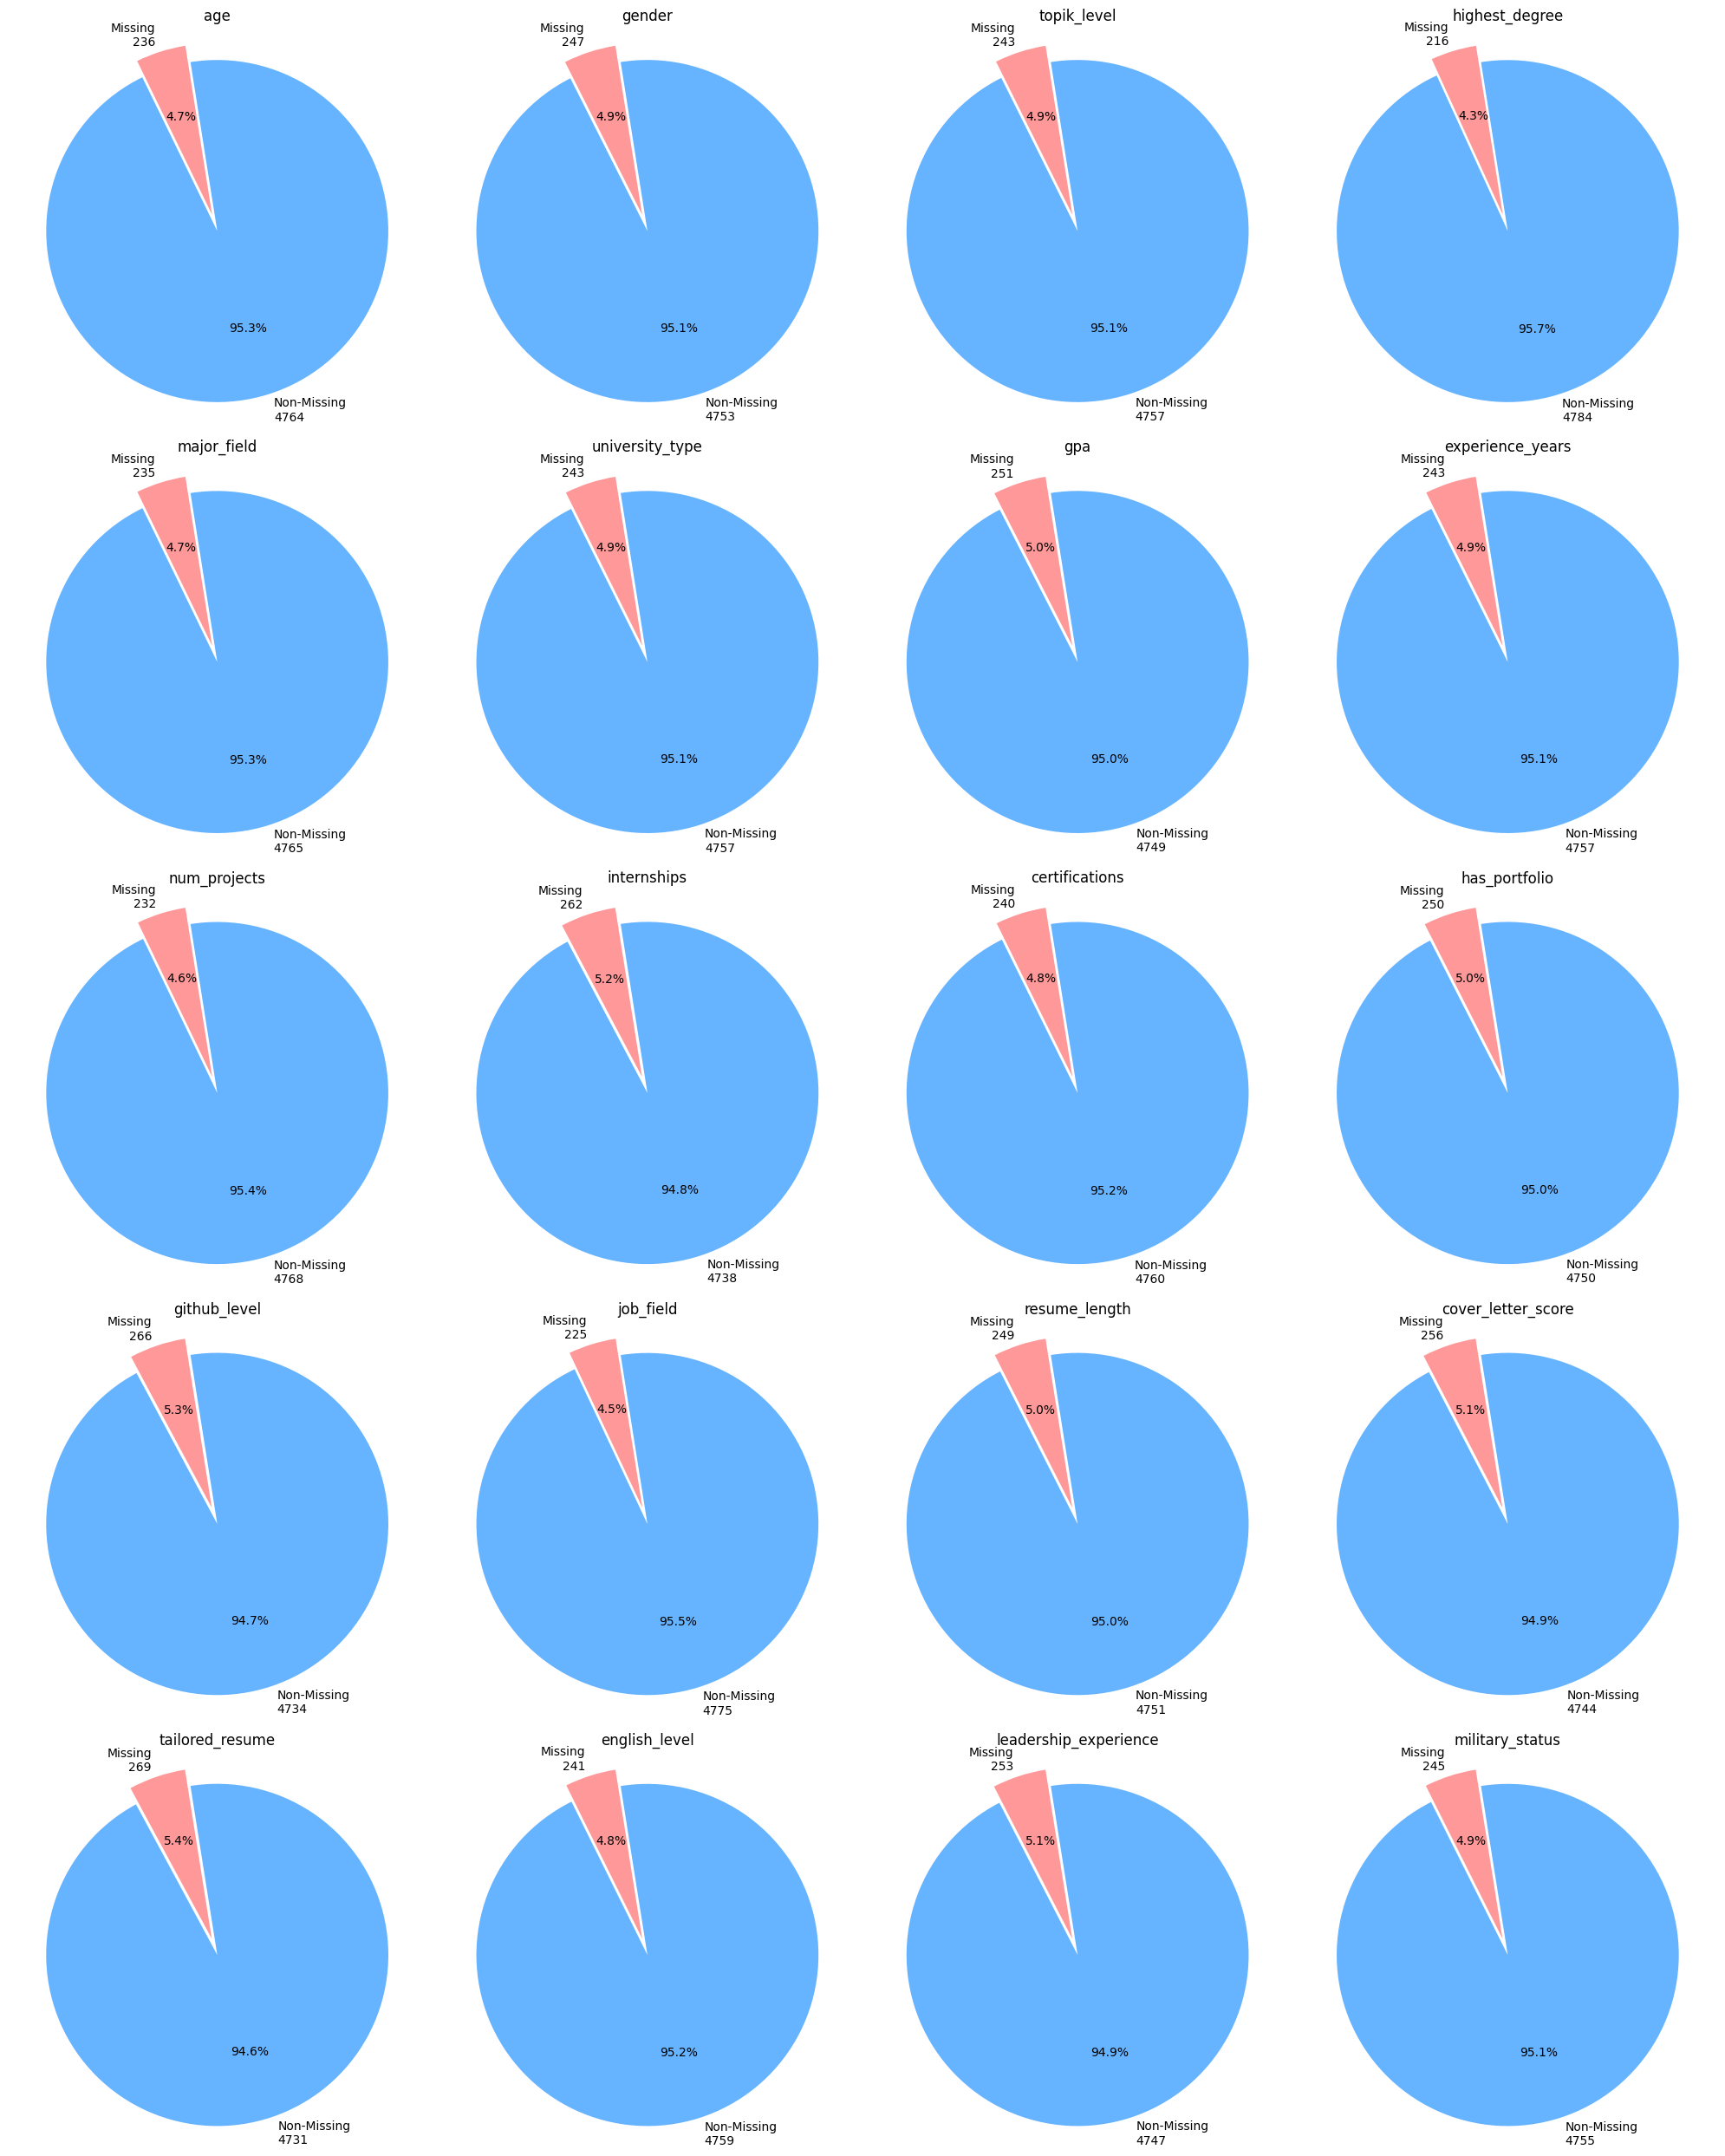

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.flatten()  

for idx, column in enumerate(df.columns):
    if idx >= 20: 
        break
    missing = df[column].isna().sum()
    non_missing = df[column].notna().sum()
    
    labels = [f'Missing\n{missing}', f'Non-Missing\n{non_missing}']
    sizes = [missing, non_missing]
    colors = ['#ff9999', '#66b3ff']
    explode = (0.1, 0)
    
    axes[idx].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=99)
    axes[idx].axis('equal')
    axes[idx].set_title(f'{column}')

# Hide any unused subplots
for idx in range(len(df.columns), 20):
    axes[idx].axis('off')

plt.tight_layout()

In [38]:
df.isnull().mean().sort_values(ascending=False) * 100

tailored_resume          5.38
github_level             5.32
internships              5.24
cover_letter_score       5.12
leadership_experience    5.06
gpa                      5.02
has_portfolio            5.00
resume_length            4.98
gender                   4.94
military_status          4.90
university_type          4.86
experience_years         4.86
topik_level              4.86
english_level            4.82
certifications           4.80
age                      4.72
major_field              4.70
num_projects             4.64
job_field                4.50
pass_screening           4.46
highest_degree           4.32
dtype: float64

## Missing Values Observation

- About 5% of the dataset contains missing values, distributed randomly across features.
- The most commonly missing columns are likely to be `"gpa"`, `"toeic_score"`, or `"internships"`, which reflect optional or inconsistently reported information in real resumes.
- Since the missing values were synthetically added, they do not reflect real-world data collection bias but help simulate preprocessing scenarios.
- Imputation strategies such as:
  - `mean/median` for numerical columns (e.g., GPA),
  - or filling with `mode` or `"Unknown"`/`"No Experience"` for categorical columns (e.g., internships),
  can be applied.
- The dataset is still usable and does not require heavy cleanup.




.



.


#### Checking the skewness of columns before scaling to apply a right scaling technique

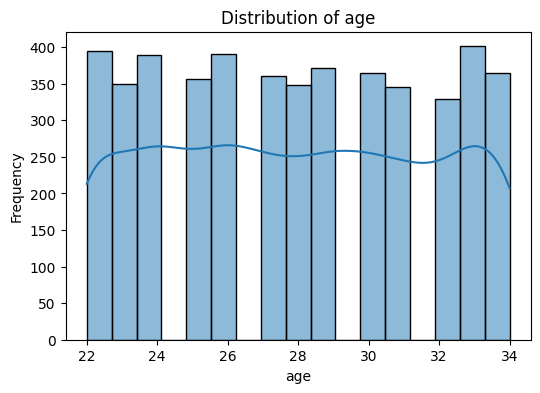

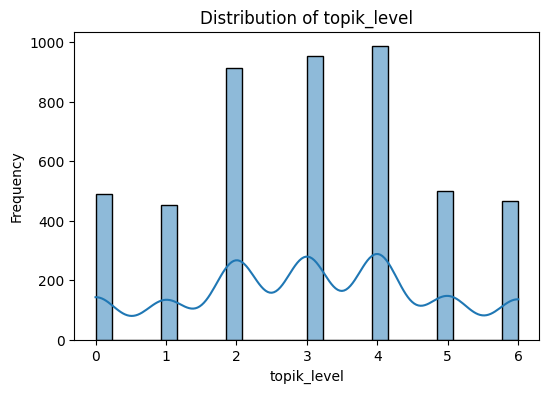

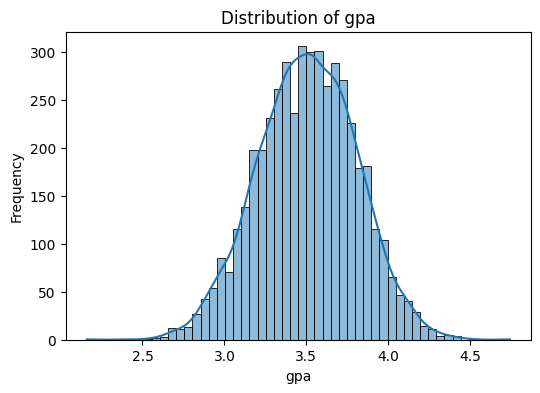

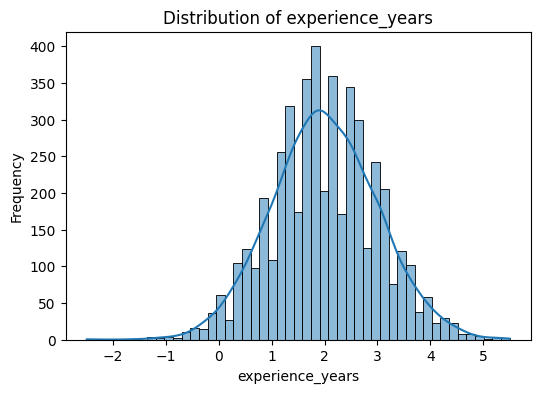

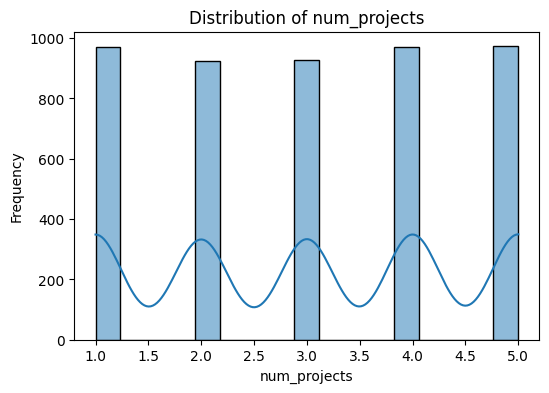

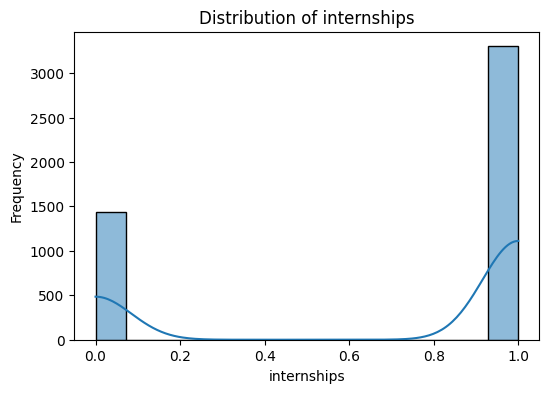

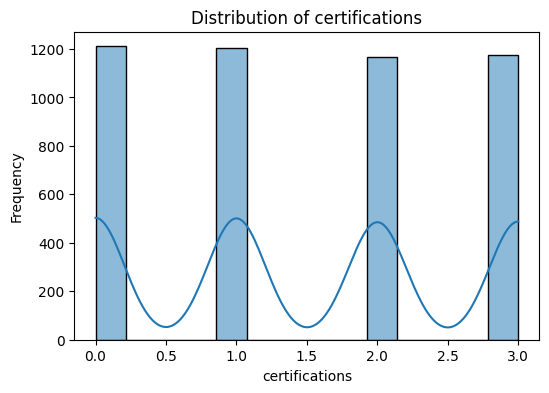

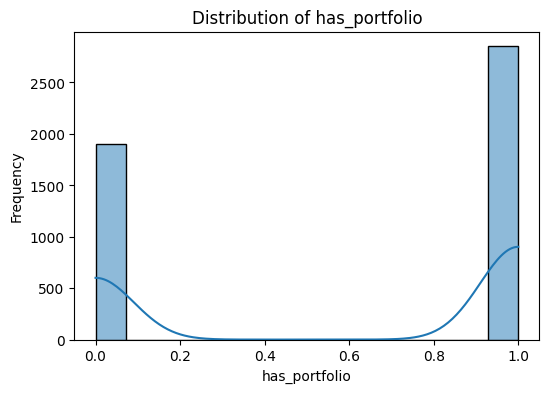

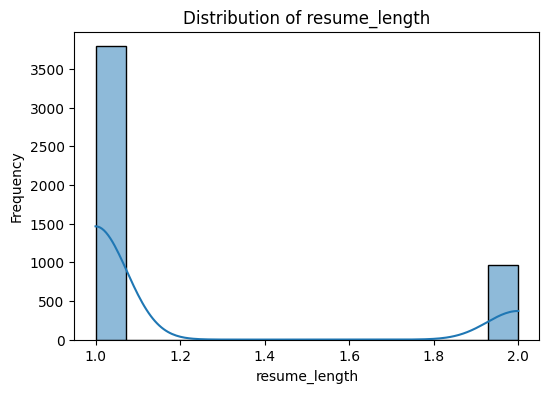

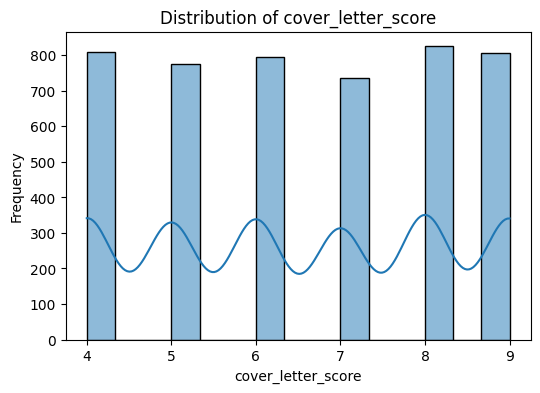

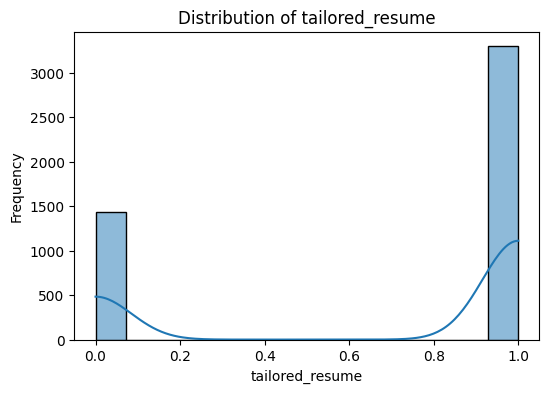

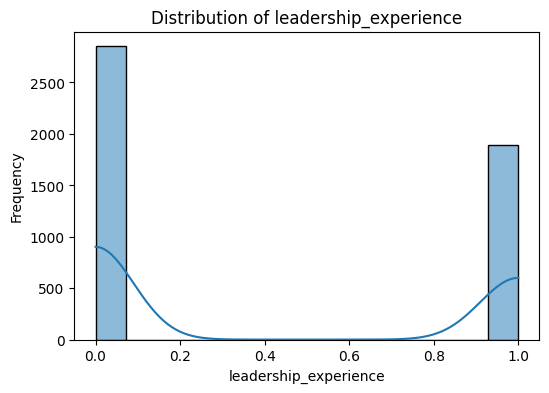

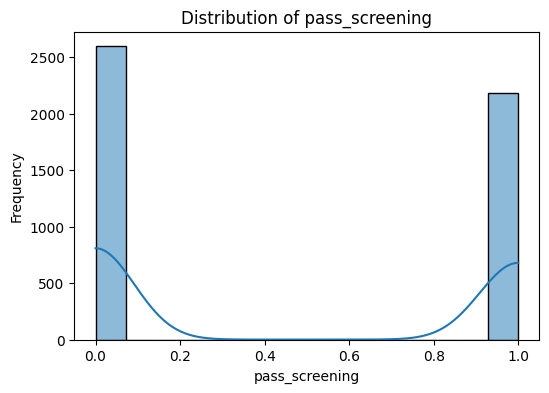

In [40]:
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

As can be seen on the histoplot, dataset is symmetrical, evenly distributed, it is ok to go with  standard scaling technique.

### Feature vs Target

In [59]:
df['pass_screening'] = df['pass_screening'].astype(int)

# Encode categorical variables (for mutual info)
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, drop_first=True)

# Separate features and target
X = df_encoded.drop("pass_screening", axis=1)
y = df_encoded["pass_screening"]

# Compute mutual information
mi_scores = mutual_info_classif(X, y)
mi_scores_df = pd.DataFrame(mi_scores, index=X.columns, columns=["Mutual Info"])
mi_scores_df = mi_scores_df.sort_values(by="Mutual Info", ascending=False)

mi_scores_df

,Mutual Info
experience_years,0.091821
cover_letter_score,0.068224
num_projects,0.041746
topik_level,0.031819
tailored_resume,0.024586
has_portfolio,0.021513
internships,0.019177
certifications,0.017061
age,0.015600
job_field_Software Dev,0.014786


Some categories of features, like `github_level_Medium` or `university_type_SKY`, showed no connection with whether an applicant passed the screening. But these are just parts of bigger features, and other categories in the same features did show importance. So, I won’t remove these features now. Instead, I’ll keep the original columns and let the model decide which parts matter during training.

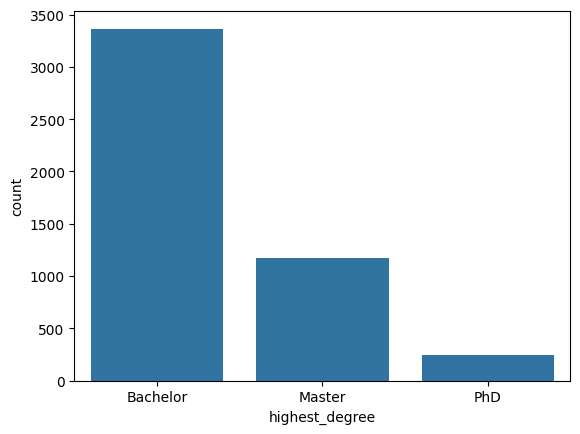

In [17]:
sns.countplot(x='highest_degree', data=df)
plt.show()

Numeric features by target to explore relationships

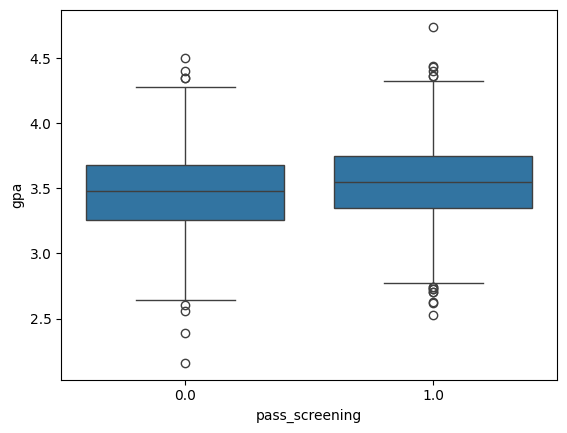

In [19]:
sns.boxplot(x='pass_screening', y='gpa', data=df)
plt.show()

Relationship between major and target

In [20]:
pd.crosstab(df['major_field'], df['pass_screening'])

pass_screening,0.0,1.0
major_field,,
Business,479,419
CS,455,442
Data Science,511,416
Economics,528,416
Industrial Eng,499,388


Among applicants from the Business major, the 서류합격 rate was fairly balanced (479 pass, 419 fail), or in case of gpa (average 3.5 for fail, 3.65 for pass )suggesting that major or gpa alone may not be a strong predictor of resume screening results.
This could mean that companies are evaluating applicants on other factors, such as internships, certifications, or skills, regardless of their academic major."

### Distribution of target label


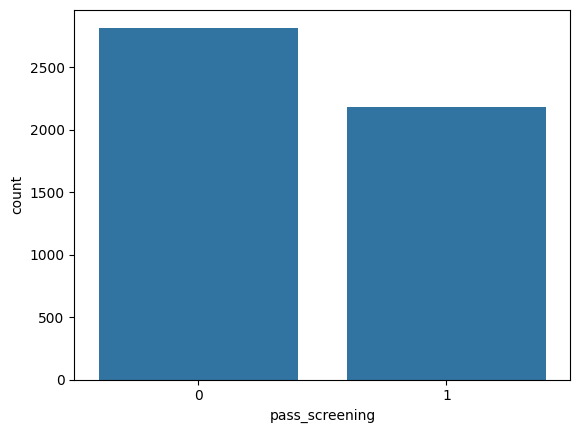

In [63]:
df['pass_screening'].value_counts(normalize=True)
sns.countplot(x='pass_screening', data=df)
plt.show()

In [64]:
df['pass_screening'].value_counts()

pass_screening
0    2819
1    2181
Name: count, dtype: int64

A dataset is considered evenly distributed (balanced) if the classes have roughly equal proportions, typically close to 50% each. A common rule of thumb is that a class ratio up to 60:40 (or 1.5:1) is still considered reasonably balanced for binary classification, though this depends on the model and problem. In our case, target class ratio is `54% vs 46%`, which is evenly distributed.